# Accident Severity Prediction

#  Import Libraries

In [1]:
!pip install seaborn

In [2]:
!pip install category_encoders

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import category_encoders as ce
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import itertools
import warnings

warnings.filterwarnings('ignore')

#  Data Preparation

##  Read the Data

In [4]:
df_asp = pd.read_csv('Vehicle Collision.csv')


In [5]:
df_asp.head()

,UNIQUE_ID,COLLISION_ID,CRASH_DATE,CRASH_TIME,PERSON_ID,PERSON_TYPE,PERSON_INJURY,VEHICLE_ID,PERSON_AGE,EJECTION,...,BODILY_INJURY,POSITION_IN_VEHICLE,SAFETY_EQUIPMENT,PED_LOCATION,PED_ACTION,COMPLAINT,PED_ROLE,CONTRIBUTING_FACTOR_1,CONTRIBUTING_FACTOR_2,PERSON_SEX
0,10253606,4230743.0,10/24/2019,19:15,84bcb3a7-d201-4c61-9e30-fe29268c1074,Occupant,Injured,19143343.0,27.0,Not Ejected,...,Back,Driver,Lap Belt & Harness,NaN,NaN,Complaint of Pain or Nausea,Driver,NaN,NaN,M
1,10248708,4229547.0,10/26/2019,1:15,a8904763-2870-42f3-865c-b53d8e5156e2,Pedestrian,Injured,NaN,24.0,NaN,...,Shoulder - Upper Arm,NaN,NaN,Pedestrian/Bicyclist/Other Pedestrian at Inter...,Crossing With Signal,None Visible,Pedestrian,Unspecified,Unspecified,F
2,10254556,4230715.0,10/26/2019,8:50,1a085543-ae9d-4a69-8cd0-fb7b33380a8b,Bicyclist,Injured,19143832.0,42.0,Not Ejected,...,Knee-Lower Leg Foot,Driver,Unknown,NaN,NaN,None Visible,Driver,NaN,NaN,M
3,10250834,4230376.0,10/26/2019,19:40,f58fc41f-497e-4f30-bf49-a9a80adec8b2,Bicyclist,Injured,19141949.0,36.0,Not Ejected,...,Back,Driver,NaN,NaN,NaN,Internal,Driver,NaN,NaN,M
4,10252474,4229773.0,10/26/2019,16:50,4bf13d12-8d7a-4cb0-997f-dd6a8b1adca6,Occupant,Injured,19142773.0,50.0,Not Ejected,...,Head,"Front passenger, if two or more persons, inclu...",Lap Belt & Harness,NaN,NaN,Complaint of Pain or Nausea,Passenger,NaN,NaN,F


In [6]:
df_asp.shape

(230660, 21)

**Interpretation:** The data has 230660 observations and 21 variables

In [7]:
df_asp.columns

Index(['UNIQUE_ID', 'COLLISION_ID', 'CRASH_DATE', 'CRASH_TIME', 'PERSON_ID',
       'PERSON_TYPE', 'PERSON_INJURY', 'VEHICLE_ID', 'PERSON_AGE', 'EJECTION',
       'EMOTIONAL_STATUS', 'BODILY_INJURY', 'POSITION_IN_VEHICLE',
       'SAFETY_EQUIPMENT', 'PED_LOCATION', 'PED_ACTION', 'COMPLAINT',
       'PED_ROLE', 'CONTRIBUTING_FACTOR_1', 'CONTRIBUTING_FACTOR_2',
       'PERSON_SEX'],
      dtype='object')

##  Check the Data Type

In [8]:
df_asp.dtypes

UNIQUE_ID                 object
COLLISION_ID             float64
CRASH_DATE                object
CRASH_TIME                object
PERSON_ID                 object
PERSON_TYPE               object
PERSON_INJURY             object
VEHICLE_ID               float64
PERSON_AGE               float64
EJECTION                  object
EMOTIONAL_STATUS          object
BODILY_INJURY             object
POSITION_IN_VEHICLE       object
SAFETY_EQUIPMENT          object
PED_LOCATION              object
PED_ACTION                object
COMPLAINT                 object
PED_ROLE                  object
CONTRIBUTING_FACTOR_1     object
CONTRIBUTING_FACTOR_2     object
PERSON_SEX                object
dtype: object

##  Remove Insignificant Variables

The columns `UNIQUE_ID `,`COLLISION_ID`,`PERSON_ID`,`VEHICLE_ID`  which is redundant for further analysis. Thus, we drop the columns.

In [9]:
df_asp= df_asp.drop(["UNIQUE_ID", "COLLISION_ID", "PERSON_ID", "VEHICLE_ID"], axis=1)

## Handling Insignificant Variables 

In [10]:
df_asp = df_asp.fillna({
    'SAFETY_EQUIPMENT': 'Unknown',
    'PED_LOCATION': 'Unknown',
    'CONTRIBUTING_FACTOR_1': 'Unknown',
    'CONTRIBUTING_FACTOR_2': 'Unknown',
    'EJECTION': 'Unknown',
    'POSITION_IN_VEHICLE': 'Unknown'
})


In [11]:
df_asp["PERSON_INJURY"].value_counts()

PERSON_INJURY
Injured    229633
Killed       1023
Name: count, dtype: int64

In [12]:
df_asp= df_asp.dropna(subset=['PERSON_AGE'])
df_asp['PERSON_AGE'] = df_asp['PERSON_AGE'].apply(lambda x: df_asp['PERSON_AGE'].mean() if x < 0 or x > 100 or x == 0 else x)
df_asp = df_asp.dropna(subset=['PED_ACTION', 'CONTRIBUTING_FACTOR_1', 'CONTRIBUTING_FACTOR_2'])
df_asp= df_asp[df_asp['PERSON_SEX'] != 'U']


In [13]:
df_asp['NEW_AGE_CAT'] = 'young'
df_asp.loc[(df_asp['PERSON_AGE'] > 21) & (df_asp['PERSON_AGE'] < 50), 'NEW_AGE_CAT'] = 'mature'
df_asp.loc[df_asp['PERSON_AGE'] > 50, 'NEW_AGE_CAT'] = 'senior'


In [14]:
df_asp['CRASH_DATE'] = pd.to_datetime(df_asp['CRASH_DATE'])
df_asp['CRASH_MONTH'] = df_asp['CRASH_DATE'].dt.month
df_asp['CRASH_DATE'] = df_asp['CRASH_DATE'].map(pd.Timestamp.timestamp)


In [15]:
df_asp.columns

Index(['CRASH_DATE', 'CRASH_TIME', 'PERSON_TYPE', 'PERSON_INJURY',
       'PERSON_AGE', 'EJECTION', 'EMOTIONAL_STATUS', 'BODILY_INJURY',
       'POSITION_IN_VEHICLE', 'SAFETY_EQUIPMENT', 'PED_LOCATION', 'PED_ACTION',
       'COMPLAINT', 'PED_ROLE', 'CONTRIBUTING_FACTOR_1',
       'CONTRIBUTING_FACTOR_2', 'PERSON_SEX', 'NEW_AGE_CAT', 'CRASH_MONTH'],
      dtype='object')

# Exploratory Data Analysis 

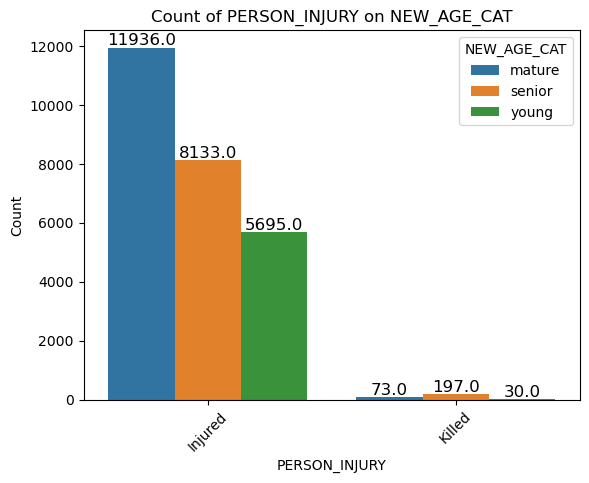

In [16]:
ax = sns.countplot(x="PERSON_INJURY", hue='NEW_AGE_CAT', data=df_asp)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.title('Count of PERSON_INJURY on NEW_AGE_CAT' )
plt.xlabel('PERSON_INJURY')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

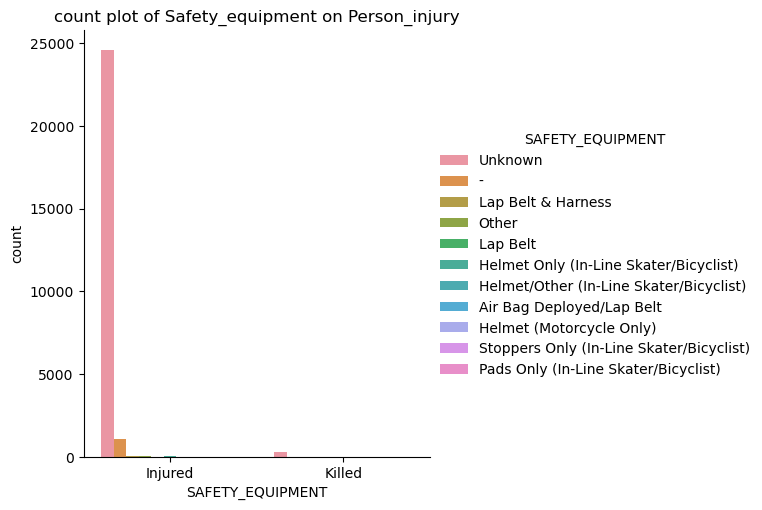

In [17]:
sns.catplot(data=df_asp, x='PERSON_INJURY', hue='SAFETY_EQUIPMENT', kind='count')
plt.title("count plot of Safety_equipment on Person_injury")
plt.xlabel("SAFETY_EQUIPMENT")
plt.show()


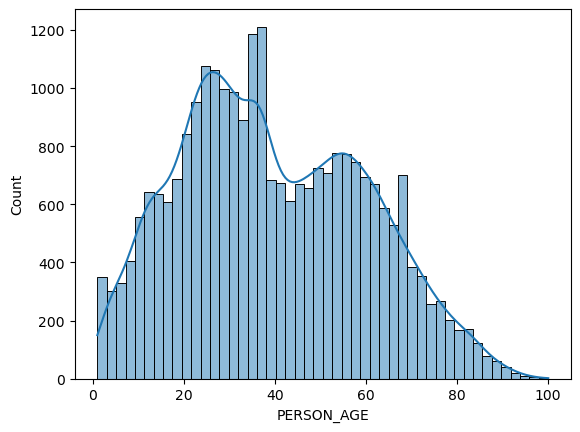

In [18]:
sns.histplot(x="PERSON_AGE",data=df_asp,kde=True)
plt.show()

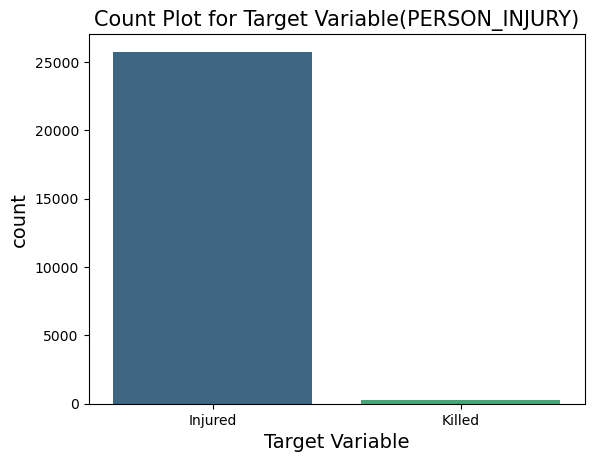

In [19]:
sns.countplot(x='PERSON_INJURY', data=df_asp,palette='viridis')
plt.title('Count Plot for Target Variable(PERSON_INJURY)',fontsize=15)
plt.xlabel("Target Variable",fontsize=14) 
plt.ylabel("count",fontsize=14)
plt.show()

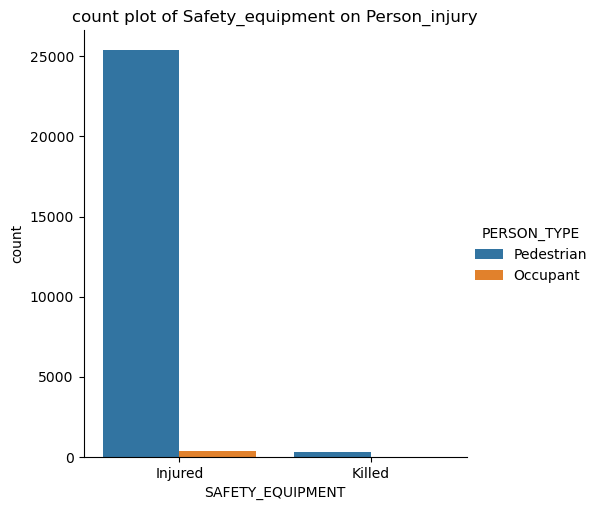

In [20]:
sns.catplot(data=df_asp, x='PERSON_INJURY', hue='PERSON_TYPE', kind='count')
plt.title("count plot of Safety_equipment on Person_injury")
plt.xlabel("SAFETY_EQUIPMENT")
plt.show()


In [21]:
df_asp['PERSON_INJURY'].replace({'Killed': 0, 'Injured': 1}, inplace=True)


# Encoding for categorical Variables using Co-ordinal Encoder

In [22]:
df_cat = [col for col in df_asp.columns if df_asp[col].dtype == 'object']
encode= ce.OrdinalEncoder(cols=df_cat, handle_unknown='impute')
df_asp_encoded = encode.fit_transform(df_asp)
df_asp_encoded.head()

,CRASH_DATE,CRASH_TIME,PERSON_TYPE,PERSON_INJURY,PERSON_AGE,EJECTION,EMOTIONAL_STATUS,BODILY_INJURY,POSITION_IN_VEHICLE,SAFETY_EQUIPMENT,PED_LOCATION,PED_ACTION,COMPLAINT,PED_ROLE,CONTRIBUTING_FACTOR_1,CONTRIBUTING_FACTOR_2,PERSON_SEX,NEW_AGE_CAT,CRASH_MONTH
1,1.572048e+09,1,1,1,24.0,1,1,1,1,1,1,1,1,1,1,1,1,1,10
24,1.572048e+09,2,1,1,67.0,1,1,2,2,1,1,1,2,1,1,1,1,2,10
29,1.571789e+09,3,1,1,59.0,1,1,3,1,1,2,2,3,1,1,1,1,2,10
32,1.572048e+09,4,1,1,14.0,1,1,4,1,1,1,1,4,1,1,1,1,3,10
34,1.572048e+09,5,1,1,18.0,1,1,3,1,1,1,1,2,1,1,1,1,3,10


In [23]:
df_asp_encoded["PERSON_INJURY"].value_counts()

PERSON_INJURY
1    25764
0      300
Name: count, dtype: int64

In [42]:
X.columns

Index(['CRASH_DATE', 'CRASH_TIME', 'PERSON_TYPE', 'PERSON_AGE', 'EJECTION',
       'EMOTIONAL_STATUS', 'BODILY_INJURY', 'POSITION_IN_VEHICLE',
       'SAFETY_EQUIPMENT', 'PED_LOCATION', 'PED_ACTION', 'COMPLAINT',
       'PED_ROLE', 'CONTRIBUTING_FACTOR_1', 'CONTRIBUTING_FACTOR_2',
       'PERSON_SEX', 'NEW_AGE_CAT', 'CRASH_MONTH'],
      dtype='object')

In [24]:
X = df_asp_encoded.drop(['PERSON_INJURY'], axis=1)
y = df_asp_encoded['PERSON_INJURY']


## Train -Test Split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Training Multiple Models to find the best Machine Learning Model

In [26]:
models = [
    ("Log", LogisticRegression()),
    ("KNC", KNeighborsClassifier()),
    ("DTC", DecisionTreeClassifier()),
    ("RFC", RandomForestClassifier()),
    ("SVM", SVC())
]

In [27]:
for name, model in models:
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=43)
    scores = cross_validate(model, X, y, cv=kfold, scoring=['accuracy', 'precision', 'recall', 'f1'])
    
    print(f'Model: {name}')
    print(f'Accuracy: {scores["test_accuracy"].mean()}')
    print(f'Precision: {scores["test_precision"].mean()}')
    print(f'Recall: {scores["test_recall"].mean()}')
    print(f'F1 Score: {scores["test_f1"].mean()}')
    print('--------------------------------------')

Model: Log
Accuracy: 0.9884898710187752
Precision: 0.9884898710187752
Recall: 1.0
F1 Score: 0.9942116230264112
--------------------------------------
Model: KNC
Accuracy: nan
Precision: nan
Recall: nan
F1 Score: nan
--------------------------------------
Model: DTC
Accuracy: 0.990062891063268
Precision: 0.9956084628136678
Recall: 0.9943331720170244
F1 Score: 0.9949702187381231
--------------------------------------
Model: RFC
Accuracy: 0.9945518310605209
Precision: 0.9949782296041132
Recall: 0.9995342217582955
F1 Score: 0.9972507666650261
--------------------------------------
Model: SVM
Accuracy: 0.9884898710187752
Precision: 0.9884898710187752
Recall: 1.0
F1 Score: 0.9942116230264112
--------------------------------------


Confusion matrix, without normalization
[[  169   131]
 [   11 25753]]


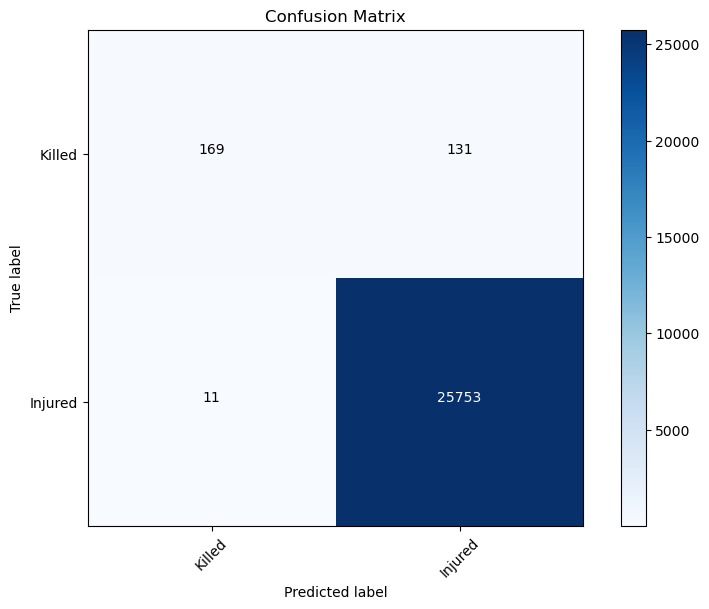

              precision    recall  f1-score   support

           0       0.94      0.56      0.70       300
           1       0.99      1.00      1.00     25764

    accuracy                           0.99     26064
   macro avg       0.97      0.78      0.85     26064
weighted avg       0.99      0.99      0.99     26064



In [28]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_pred = cross_val_predict(clf, X, y, cv=skf)
conf_mat = confusion_matrix(y, y_pred)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f' if normalize else 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(conf_mat, classes=['Killed', 'Injured'], title='Confusion Matrix')
print(classification_report(y, y_pred))

In [29]:
clf = DecisionTreeClassifier(max_depth=3, min_samples_split=3, random_state=43)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)



In [30]:
print('Accuracy:', accuracy_score(y_test, pred))
print('AUC Score:', roc_auc_score(y_test, pred))
print(classification_report(y_test, pred))


Accuracy: 0.9934782608695653
AUC Score: 0.7574729920401104
              precision    recall  f1-score   support

           0       0.93      0.52      0.66        97
           1       0.99      1.00      1.00      7723

    accuracy                           0.99      7820
   macro avg       0.96      0.76      0.83      7820
weighted avg       0.99      0.99      0.99      7820



Confusion matrix, without normalization
[[  50   47]
 [   4 7719]]


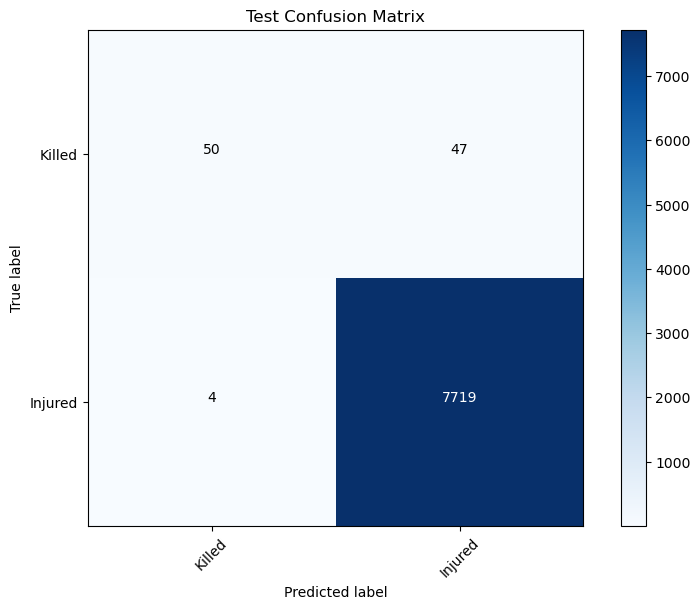

In [31]:
conf_mat_test = confusion_matrix(y_test, pred)
plot_confusion_matrix(conf_mat_test, classes=['Killed', 'Injured'], title='Test Confusion Matrix')


In [32]:
!pip install imblearn

## Resampling the data to handle class imbalance using SMOTE Analysis

In [33]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)


In [34]:
y_res.value_counts()

PERSON_INJURY
1    25764
0    25764
Name: count, dtype: int64

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)


In [36]:
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')


In [37]:
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

In [38]:
print('Accuracy:', accuracy_score(y_test, pred))
print('AUC Score:', roc_auc_score(y_test, pred))
print(classification_report(y_test, pred))

Accuracy: 0.991461284688531
AUC Score: 0.9914153640811801
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7779
           1       1.00      0.98      0.99      7680

    accuracy                           0.99     15459
   macro avg       0.99      0.99      0.99     15459
weighted avg       0.99      0.99      0.99     15459



## Ploting Confusion Matrix

Confusion matrix, without normalization
[[7768   11]
 [ 121 7559]]


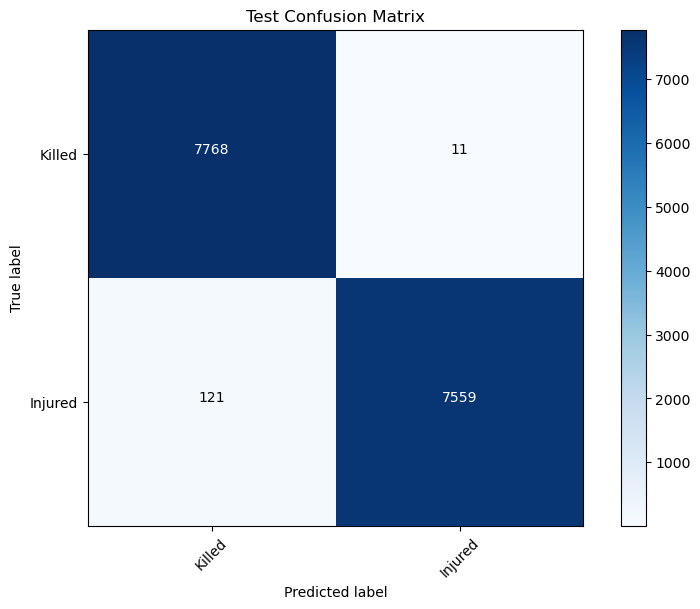

In [39]:
conf_mat_test = confusion_matrix(y_test, pred)

plot_confusion_matrix(conf_mat_test, classes=['Killed', 'Injured'], title='Test Confusion Matrix')

**Interpretation:** Based on the provided metrics, RFC stands out as the best-performing model overall. It achieves a good balance between precision and recall.

Hence, we will go with Random Forest Classifier as our final model as it is quite evident that it performs best for our Accident Severity Prediction.
